# Finetune ResNet50


With 1000 x 400 melspectrogram images normalized on the train set (instead of ImageNet stats) without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:

FINETUNED_MODEL = 'resnet50_normalized'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the mel spectrogram images


In [6]:
from datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="Training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the validation function


In [8]:
def validate(model, valloader, criterion, device):
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    # Switch to evaluation mode
    model.eval()

    epoch_start = time.time()
    pbar = tqdm(enumerate(valloader), total=len(
        valloader), desc="Validating")

    with torch.no_grad():
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Calculate time metrics
            elapsed = time.time() - epoch_start
            progress = (i + 1) / len(valloader)
            eta = elapsed / progress - elapsed

            # Update progress bar with current loss and ETA
            pbar.set_postfix({
                "Loss": f"{loss.item()}",
                "Elapsed": f"{elapsed:.4f}s",
                "ETA": f"{eta:.4f}s"
            })

    val_loss = val_loss / len(valloader)
    val_accuracy = val_correct / val_total * 100

    return val_loss, val_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, valloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        val_loss, val_accuracy = validate(
            model, valloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(
            f'Validation Loss: {val_loss} - Validation Accuracy: {val_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Check if current model is best performing using test_accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, val_losses, val_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, val_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, val_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(val_accuracies)),
             val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Compute the mean and standard deviation of the train dataset


In [14]:
def compute_mean_std(dataset, batch_size=128, num_workers=8):
    loader = DataLoader(dataset, batch_size=batch_size,
                        num_workers=num_workers, shuffle=False)
    mean = 0.0
    std = 0.0
    total_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        # flatten H and W dimensions
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean, std


# Temporary transform: only apply Resize and ToTensor (no normalization)
temp_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create a temporary dataset to compute statistics
temp_dataset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=temp_transform)
mean, std = compute_mean_std(temp_dataset)
print("Computed Mean:", mean)
print("Computed Std:", std)

Computed Mean: tensor([0.2126, 0.0765, 0.1826])
Computed Std: tensor([0.2794, 0.1221, 0.1852])


Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    # Normalize to the train set
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


Validating: 100%|██████████| 75/75 [00:10<00:00,  7.44it/s, Loss=1.3110549449920654, Elapsed=21.1829s, ETA=0.0000s] 


Epoch 1 completed in 75.9392s
Train Loss: 1.4317342442584176 - Train Accuracy: 43.538137988738384
Validation Loss: 1.3624867645899454 - Validation Accuracy: 46.71802448290418

Epoch 2/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.4862284660339355, Elapsed=20.3473s, ETA=0.0000s] 


Epoch 2 completed in 73.6506s
Train Loss: 1.295503301772079 - Train Accuracy: 49.16442414237579
Validation Loss: 1.2729211982091269 - Validation Accuracy: 50.62262558041367

Epoch 3/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.70it/s, Loss=1.7123830318450928, Elapsed=20.4532s, ETA=0.0000s] 


Epoch 3 completed in 73.6424s
Train Loss: 1.2492439745134012 - Train Accuracy: 51.382827163564826
Validation Loss: 1.2736957184473674 - Validation Accuracy: 50.62262558041367

Epoch 4/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.74it/s, Loss=1.5255680084228516, Elapsed=20.2993s, ETA=0.0000s] 


Epoch 4 completed in 73.2986s
Train Loss: 1.2364909714357013 - Train Accuracy: 51.74012347074919
Validation Loss: 1.2582660166422526 - Validation Accuracy: 52.03672435626847

Epoch 5/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.4240370988845825, Elapsed=20.1730s, ETA=0.0000s] 


Epoch 5 completed in 73.0942s
Train Loss: 1.210402104206857 - Train Accuracy: 52.854978403925735
Validation Loss: 1.259072283109029 - Validation Accuracy: 50.802026171380334

Epoch 6/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.4160645008087158, Elapsed=20.4307s, ETA=0.0000s] 


Epoch 6 completed in 73.1777s
Train Loss: 1.1956917274894052 - Train Accuracy: 53.601230184753845
Validation Loss: 1.216899317105611 - Validation Accuracy: 53.50358801181934

Epoch 7/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.2464730739593506, Elapsed=20.4232s, ETA=0.0000s] 


Epoch 7 completed in 73.3471s
Train Loss: 1.17846138249932 - Train Accuracy: 54.431152619796016
Validation Loss: 1.2214550733566285 - Validation Accuracy: 52.89151540734487

Epoch 8/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.75it/s, Loss=1.5451698303222656, Elapsed=20.2977s, ETA=0.0000s] 


Epoch 8 completed in 73.1180s
Train Loss: 1.1799688847423289 - Train Accuracy: 54.36783428687727
Validation Loss: 1.2071760018666586 - Validation Accuracy: 53.1975517095821

Epoch 9/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.71it/s, Loss=1.278641700744629, Elapsed=20.3309s, ETA=0.0000s]  


Epoch 9 completed in 73.1757s
Train Loss: 1.1611256129135286 - Train Accuracy: 55.07790416318039
Validation Loss: 1.189531597296397 - Validation Accuracy: 54.60109750949768

Epoch 10/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.4330089092254639, Elapsed=20.4281s, ETA=0.0000s] 


Epoch 10 completed in 73.4291s
Train Loss: 1.1490232438021313 - Train Accuracy: 55.7879740394835
Validation Loss: 1.1958889706929525 - Validation Accuracy: 54.010130856901654

Epoch 11/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.099489450454712, Elapsed=20.1837s, ETA=0.0000s]  


Epoch 11 completed in 73.0114s
Train Loss: 1.1435132822549412 - Train Accuracy: 55.73596255172881
Validation Loss: 1.1936791054407756 - Validation Accuracy: 54.26340227944281

Epoch 12/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.72it/s, Loss=1.52947998046875, Elapsed=20.3583s, ETA=0.0000s]   


Epoch 12 completed in 73.2486s
Train Loss: 1.1373373373395446 - Train Accuracy: 56.39628230931005
Validation Loss: 1.2023235273361206 - Validation Accuracy: 53.38750527648797

Epoch 13/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.68it/s, Loss=1.3959934711456299, Elapsed=20.4969s, ETA=0.0000s] 


Epoch 13 completed in 73.5370s
Train Loss: 1.1304612683422992 - Train Accuracy: 56.52744171321318
Validation Loss: 1.1724770220120748 - Validation Accuracy: 55.13929928239764

Epoch 14/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.87it/s, Loss=1.3793225288391113, Elapsed=20.1971s, ETA=0.0000s] 


Epoch 14 completed in 72.6224s
Train Loss: 1.1266977223702248 - Train Accuracy: 56.64955564098505
Validation Loss: 1.1707438810666402 - Validation Accuracy: 55.08653440270156

Epoch 15/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.80it/s, Loss=1.2108845710754395, Elapsed=20.2219s, ETA=0.0000s] 


Epoch 15 completed in 73.1881s
Train Loss: 1.1172959410041743 - Train Accuracy: 56.95484046041474
Validation Loss: 1.1694763668378194 - Validation Accuracy: 53.820177289995776

Epoch 16/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.84it/s, Loss=1.332680344581604, Elapsed=20.2517s, ETA=0.0000s]  


Epoch 16 completed in 72.6509s
Train Loss: 1.1137806187475348 - Train Accuracy: 57.282738970172545
Validation Loss: 1.1730235528945923 - Validation Accuracy: 53.461376108062474

Epoch 17/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.85it/s, Loss=1.299888014793396, Elapsed=20.1640s, ETA=0.0000s]  


Epoch 17 completed in 72.4788s
Train Loss: 1.109220585037518 - Train Accuracy: 57.36414825535378
Validation Loss: 1.153540080388387 - Validation Accuracy: 55.8252427184466

Epoch 18/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.78it/s, Loss=1.3426145315170288, Elapsed=20.2525s, ETA=0.0000s] 


Epoch 18 completed in 72.9406s
Train Loss: 1.1062706519413545 - Train Accuracy: 57.32118224373035
Validation Loss: 1.146188505490621 - Validation Accuracy: 55.835795694385816

Epoch 19/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.91it/s, Loss=1.335247278213501, Elapsed=20.1745s, ETA=0.0000s]  


Epoch 19 completed in 72.4387s
Train Loss: 1.0976571809349722 - Train Accuracy: 57.80737658578503
Validation Loss: 1.157579468091329 - Validation Accuracy: 55.6775010552976

Epoch 20/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.82it/s, Loss=1.2900947332382202, Elapsed=20.1391s, ETA=0.0000s] 


Epoch 20 completed in 72.8010s
Train Loss: 1.0996980189932564 - Train Accuracy: 57.78024015739128
Validation Loss: 1.14886133035024 - Validation Accuracy: 55.33980582524271

Epoch 21/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.262387990951538, Elapsed=20.5526s, ETA=0.0000s]  


Epoch 21 completed in 72.7287s
Train Loss: 1.093050588073069 - Train Accuracy: 58.11944551231315
Validation Loss: 1.1643202455838522 - Validation Accuracy: 55.26593499366822

Epoch 22/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.83it/s, Loss=1.5531458854675293, Elapsed=20.2183s, ETA=0.0000s] 


Epoch 22 completed in 72.5660s
Train Loss: 1.081538213126232 - Train Accuracy: 58.51744646208815
Validation Loss: 1.216231730779012 - Validation Accuracy: 51.17138032925285

Epoch 23/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.77it/s, Loss=1.01301908493042, Elapsed=20.2515s, ETA=0.0000s]   


Epoch 23 completed in 72.6473s
Train Loss: 1.0747251553687056 - Train Accuracy: 58.93127699509283
Validation Loss: 1.1783786114056904 - Validation Accuracy: 54.495567750105536

Epoch 24/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.65it/s, Loss=1.421755075454712, Elapsed=21.2968s, ETA=0.0000s]  


Epoch 24 completed in 74.0032s
Train Loss: 1.0801257346406838 - Train Accuracy: 58.56041247371159
Validation Loss: 1.1480930042266846 - Validation Accuracy: 56.606162937948504

Epoch 25/25


Validating: 100%|██████████| 75/75 [00:09<00:00,  7.73it/s, Loss=1.1359249353408813, Elapsed=20.2723s, ETA=0.0000s] 

Epoch 25 completed in 73.2077s
Train Loss: 1.0713527505797458 - Train Accuracy: 59.010424911241266
Validation Loss: 1.1571593364079793 - Validation Accuracy: 54.938792739552554



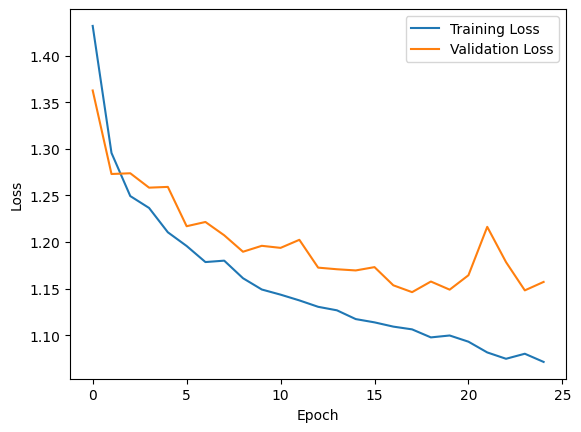

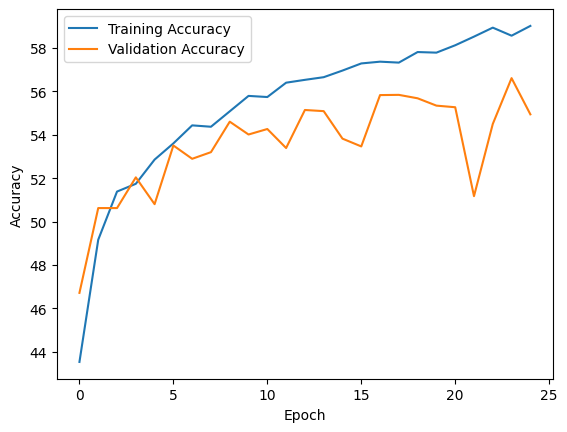

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=128,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, val_losses, val_accuracies = train_epochs(
    model, trainloader, valloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, val_losses)
plot_accuracy(train_accuracies, val_accuracies)

Define the function to plot the confusion matrix


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()

Define the function to evaluate the best model on the test set


In [18]:
def load_and_evaluate_best_model(model, testloader, criterion, device, model_path):
    # Load the best model weights
    model.load_state_dict(torch.load(model_path))
    model.eval()

    all_preds = []
    all_labels = []
    running_loss = 0.0
    correct = 0
    total = 0

    print("Evaluating best model on test set...")
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate final metrics
    test_loss = running_loss / len(testloader)
    test_accuracy = 100 * correct / total

    print(f"\nTest Results (Best Model):")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_preds, all_labels

Evaluate the best model on the test set


C:\Users\profi\AppData\Local\Temp\ipykernel_12252\3579996063.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Evaluating best model on test set...


Testing: 100%|██████████| 75/75 [00:21<00:00,  3.47it/s]


Test Results (Best Model):
Test Loss: 1.1471
Test Accuracy: 56.28%


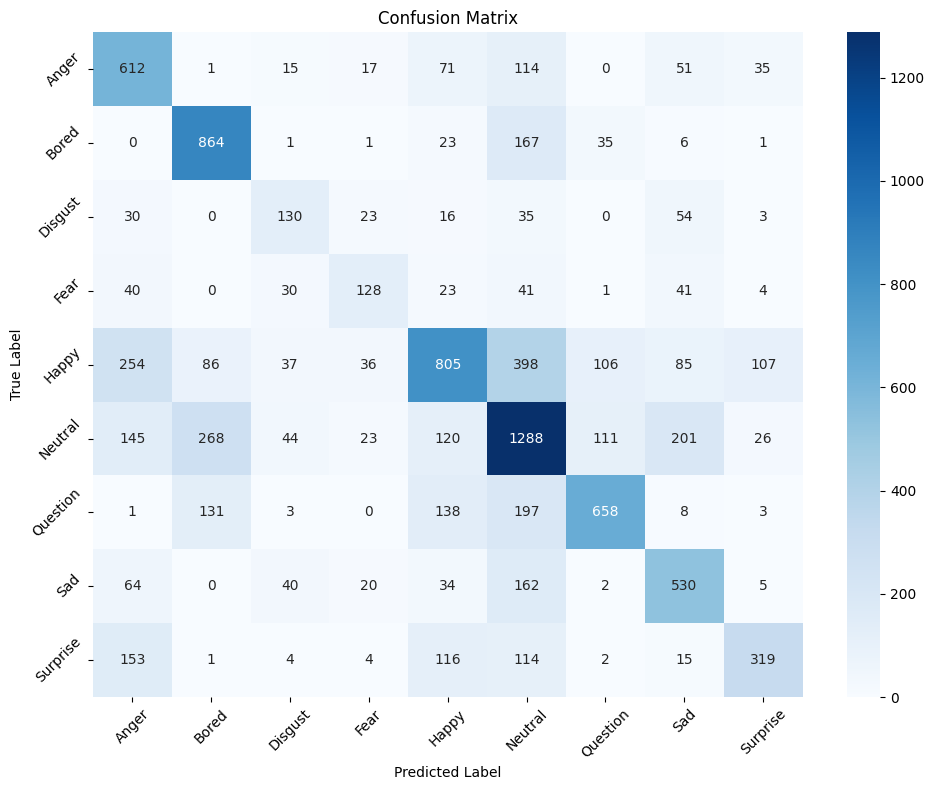

In [19]:
# Load and evaluate the best model
best_model_path = f'best_{FINETUNED_MODEL}.pt'
test_loss, test_accuracy, all_preds, all_labels = load_and_evaluate_best_model(
    model=model,
    testloader=testloader,
    criterion=criterion,
    device=device,
    model_path=best_model_path
)

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds)